# Housing in NY 

Which factors could affect the decision about where to live ? 
In this project we want to investigate which areas in New York is the best place to live. 
We take into account both the price and crime factors. The data used in this project originates from the open source database. 


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap
from urllib.request import urlopen
import json
import seaborn as sns
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, FactorRange, Legend
from bokeh.palettes import Category10, Category20, Category20b, Category20c 
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.plotting import ColumnDataSource, figure, output_file, show, reset_output, output_notebook
from sklearn import preprocessing

## Housing Data 

This section contains the basic statistic of the data, this is done to gain insight in the patterns in each of the data columns. This housing data contains prices, dates, zip codes and coordinates which are the main focus in this projects 

In [2]:
# import data:
Housedata=pd.read_csv("NYC_Citywide_Annualized_Calendar_Sales_Update.csv")

# format the date-time
Housedata['SALE DATE']=pd.to_datetime(Housedata['SALE DATE'],infer_datetime_format=True)
Housedata.head()

BOROUGH NEIGHBORHOOD BUILDING CLASS CATEGORY TAX CLASS AS OF FINAL ROLL  \
0        1      CHELSEA     21 OFFICE BUILDINGS                          4   
1        1      CHELSEA     21 OFFICE BUILDINGS                          4   
2        1      CHELSEA     21 OFFICE BUILDINGS                          4   
3        1      CHELSEA     21 OFFICE BUILDINGS                          4   
4        1      CHELSEA     21 OFFICE BUILDINGS                          4   

   BLOCK  LOT  EASE-MENT BUILDING CLASS AS OF FINAL ROLL  \
0    697    5        NaN                              O2   
1    697   23        NaN                              O6   
2    700   55        NaN                              O2   
3    712    1        NaN                              O6   
4    746   64        NaN                              O8   

                ADDRESS APARTMENT NUMBER  ...  SALE PRICE  SALE DATE  \
0  555 WEST 25TH STREET              NaN  ...    43300000 2019-03-28   
1  511 WEST 25TH STREET              NaN  ...   148254147 2019-05-23   
2  538 WEST 29TH STREET              NaN  ...    11000000 2019-03-13   
3         450 WEST 15TH              NaN  ...   591800000 2019-05-22   
4  340 WEST 23RD STREET              NaN  ...           0 2019-04-01   

    Latitude  Longitude Community Board Council District  Census Tract  \
0  40.749704 -74.004930           104.0              3.0          99.0   
1  40.749364 -74.004132           104.0              3.0          99.0   
2  40.752067 -74.002931           104.0              3.0          99.0   
3        NaN        NaN             NaN              NaN           NaN   
4  40.745809 -73.999729           104.0              3.0          93.0   

         BIN           BBL                                         NTA  
0  1012379.0  1.006970e+09  Hudson Yards-Chelsea-Flatiron-Union Square  
1  1012382.0  1.006970e+09  Hudson Yards-Chelsea-Flatiron-Union Square  
2  1012435.0  1.007000e+09  Hudson Yards-Chelsea-Flatiron-Union Square  
3        NaN           NaN                                         NaN  
4  1013367.0  1.007460e+09  Hudson Yards-Chelsea-Flatiron-Union Square  

[5 rows x 29 columns]


#### Data processing: 
The bourughs are encoded as integers, we are interested in converting them to strings.

In [3]:
Housedata['BOROUGH'] = ['MANHATTAN' if row==1 else row for row in Housedata['BOROUGH']]
Housedata['BOROUGH'] = ['BRONX' if row==2 else row for row in Housedata['BOROUGH']]
Housedata['BOROUGH'] = ['BROOKLYN' if row==3 else row for row in Housedata['BOROUGH']]
Housedata['BOROUGH'] = ['QUEENS' if row==4 else row for row in Housedata['BOROUGH']]
Housedata['BOROUGH'] = ['RICHMOND / STATEN ISLAND' if row==5 else row for row in Housedata['BOROUGH']]

Take a look at number of records in each borough of the dataset.

Text(0, 0.5, 'Counts')

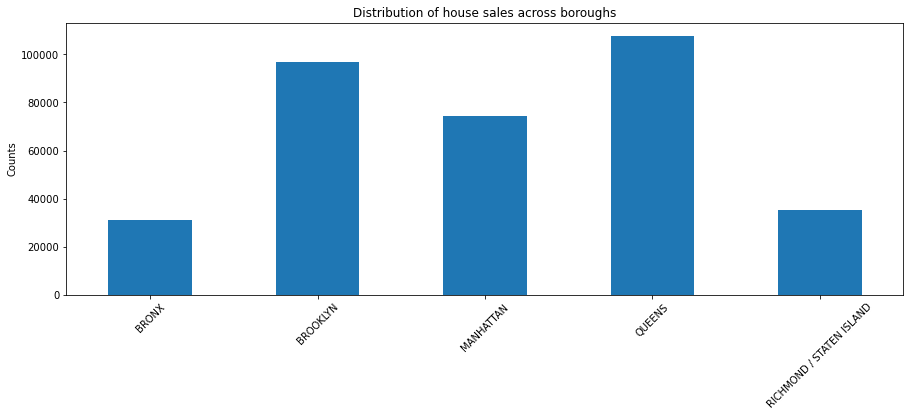

In [4]:
ax=Housedata['BOROUGH'].value_counts().sort_index().plot(kind='bar', 
                                                         rot=45, figsize= (15,5), 
                                                         title='Distribution of house sales across boroughs')
ax.set_ylabel('Counts')

#### Distribution across boroughs
The Distribution of the data across the boroughs is showin in the bar chart. As shown here, Queens and Brookelyn is the boroughs that has most house sales in this data set. 

#### The outliers affacts the data a lot
Therefore we are interested in more data processing:

In [5]:
# Removing outliers of the zip codes within NY.
Housedata = Housedata[Housedata["ZIP CODE"]>0]
Housedata = Housedata[Housedata["SALE PRICE"]>200]

Text(0.5, 1.0, 'Price distribution with outliers')

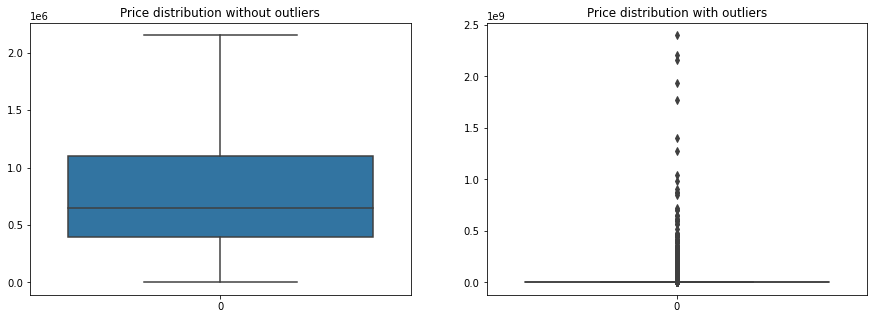

In [6]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
sns.boxplot(ax=axes[0],data=Housedata["SALE PRICE"],showfliers = False)
sns.boxplot(ax=axes[1],data=Housedata["SALE PRICE"])
axes[0].set_title('Price distribution without outliers')
axes[1].set_title('Price distribution with outliers')

For a more intuitive view of housing price distribution patterns, we chose kde plot.

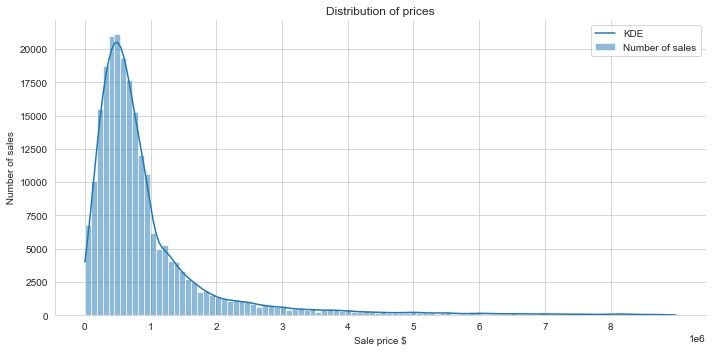

In [7]:
sns.set_style("whitegrid")
sns.displot(Housedata[(Housedata['SALE PRICE']<9000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'], 
             kde=True, bins=100, height=5, aspect=2,legend=True).set(xlabel="Sale price $", ylabel = " Number of sales")
plt.xticks(np.arange(0,9*10**6,10**6))
plt.legend(['KDE','Number of sales'])
plt.title('Distribution of prices')
plt.tight_layout()
plt.savefig("histogram_price.png")

In [8]:
total_num = Housedata[(Housedata['SALE PRICE']<9000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
under_2_mio = Housedata[(Housedata['SALE PRICE']<2000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
print(f'{under_2_mio/total_num*100:.2f}% of the houses shown in figure above, are under {2} million $')

90.09% of the houses shown in figure above, are under 2 million $


#### Outliers in the prices:
As showin in both boxplots and histogram with kernel density graph. The prices are most frequent within 4 million dollors. Whereas this plot only shows up to 9 million as the outliers are mostly located in the higher price ranges (shown in boxplot) 
The distribution of sale prices shows a normal distribution with a right tail. 

In [9]:
over_price = 8000000
price_percent= Housedata[(Housedata['SALE PRICE']>over_price)].shape[0]/Housedata.shape[0]*100
print(f'From this point on, house prices that exceeds {over_price} dollars will be removed')
print(f'The fraction of data removed is {price_percent:.2f} %')

From this point on, house prices that exceeds 8000000 dollars will be removed
The fraction of data removed is 2.34 %


In [10]:
total_num = Housedata[(Housedata['BOROUGH'] == "BROOKLYN") & (Housedata['SALE PRICE']<9000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
under_2_mio = Housedata[(Housedata['BOROUGH'] == "BROOKLYN") & (Housedata['SALE PRICE']<2000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
print(f'{under_2_mio/total_num*100:.2f}% of the houses shown in Brooklyn, are under {2} million $')

total_num = Housedata[(Housedata['BOROUGH'] == "MANHATTAN") & (Housedata['SALE PRICE']<9000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
under_2_mio = Housedata[(Housedata['BOROUGH'] == "MANHATTAN") & (Housedata['SALE PRICE']<2000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
print(f'{under_2_mio/total_num*100:.2f}% of the houses shown in MANHATTAN, are under {2} million $')

total_num = Housedata[(Housedata['BOROUGH'] == "BRONX") & (Housedata['SALE PRICE']<9000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
under_2_mio = Housedata[(Housedata['BOROUGH'] == "BRONX") & (Housedata['SALE PRICE']<2000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
print(f'{under_2_mio/total_num*100:.2f}% of the houses shown in Bronx, are under {2} million $')

total_num = Housedata[(Housedata['BOROUGH'] == "QUEENS") & (Housedata['SALE PRICE']<9000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
under_2_mio = Housedata[(Housedata['BOROUGH'] == "QUEENS") & (Housedata['SALE PRICE']<2000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
print(f'{under_2_mio/total_num*100:.2f}% of the houses in Queens, are under {2} million $')

total_num = Housedata[(Housedata['BOROUGH'] == "RICHMOND / STATEN ISLAND") & (Housedata['SALE PRICE']<9000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
under_2_mio = Housedata[(Housedata['BOROUGH'] == "RICHMOND / STATEN ISLAND") & (Housedata['SALE PRICE']<2000000) & (Housedata['SALE PRICE']>200)]['SALE PRICE'].shape[0]
print(f'{under_2_mio/total_num*100:.2f}% of the houses shown in Richmond / Staten Island, are under {2} million $')


89.94% of the houses shown in Brooklyn, are under 2 million $
74.12% of the houses shown in MANHATTAN, are under 2 million $
95.49% of the houses shown in Bronx, are under 2 million $
97.63% of the houses in Queens, are under 2 million $
99.35% of the houses shown in Richmond / Staten Island, are under 2 million $


In [11]:
## Data processing to get correct data into bins:
from bokeh.plotting import figure, output_file, save

#NoOutlier = Housedata[(Housedata['SALE PRICE']>over_price)]

max_out= 5000000
min_out = 100000
NoOutlier = Housedata[(Housedata['SALE PRICE']<max_out) & (Housedata['SALE PRICE']>min_out)] 


list_of_borough = Housedata['BOROUGH'].unique()
HistData={}
for indx,i in enumerate(list_of_borough):
    bins = 50 
    dataframe=NoOutlier[NoOutlier['BOROUGH']==i]
    column = 'SALE PRICE'

    hist, edges = np.histogram(dataframe[column], bins = bins)
    hist_df = pd.DataFrame({column: hist,
                        "left": edges[:-1],
                        "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]
    
    
    HistData[i]=ColumnDataSource(hist_df)
    
    
# create plot 
reset_output()
output_notebook()

# initialize standard settings for the plot: 
plot = figure(plot_height = 300, plot_width = 700, title = 'House prices in New York',
      x_axis_label = 'USD',
      y_axis_label = "Count")  

# Create empty dictionary for bars
bar={}
# create empty legend list
legend_it = []

# define colors for the boroughs
colors = Category10[len(list_of_borough)]

for indx,i in enumerate(list_of_borough):
    src = HistData[i]
    
    bar[i]=plot.quad(top=column, bottom=0.1, left = "left", right = "right",
                       source=src, color=colors[indx], muted_alpha=0.2,muted=True , legend_label = i) 
    
    
    #legend_it.append((i, [bar[i]]))

#legend = Legend(items=legend_it)
#legend.click_policy="mute"
#plot.add_layout(legend, 'right')

plot.legend.location = "top_right"
plot.legend.click_policy="hide"


#displays plot:
show(plot) 

output_file("bokeh_prices.html")
save(plot)

Loading BokehJS ...

'/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Social_data_project/bokeh_prices.html'

#### The distribution of prices across boroughs
For the purpose of visualization, the data has been fitlered, as most of the data will be located in the left side.
The plot here shows that queens has the most house sales in the lower price ranges
Whereas comparing Manhattan and Queens, the prices above 1mio dollars will most likely belong to Manhattan. 

Findings:
- Manhattan and Brooklyn tend to have similar profiles
- Ricchmond/staten Island is similar to Bronx. 


In [12]:
Housedata.loc[Housedata['SALE PRICE']< 10**6 , 'Price'] = 'Below 1 mio'
Housedata.loc[((Housedata['SALE PRICE'] >= 10**6) & (Housedata['SALE PRICE'] < 2*10**6)) , 'Price'] = '1-2 mio'
Housedata.loc[((Housedata['SALE PRICE'] >= 2*10**6) & (Housedata['SALE PRICE'] < 3*10**6)) , 'Price'] = '2-3 mio'
Housedata.loc[((Housedata['SALE PRICE'] >= 3*10**6) & (Housedata['SALE PRICE'] < 4*10**6)) , 'Price'] = '3-4 mio'
Housedata.loc[(Housedata['SALE PRICE'] >= 4*10**6)  , 'Price'] = 'Above 4 mio'

# Ensure you're handing it floats
Housedata['Latitude'] = Housedata['Latitude'].astype(float)
Housedata['Longitude'] = Housedata['Longitude'].astype(float)

House = Housedata[(pd.DatetimeIndex(Housedata['SALE DATE']).year == 2019)]
House['text'] = House.apply(lambda row: 'Sale price: ' + str(row['SALE PRICE']), axis=1)

<ipython-input-12-ca604c5f2f66>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House['text'] = House.apply(lambda row: 'Sale price: ' + str(row['SALE PRICE']), axis=1)


In [13]:
map_hooray = folium.Map(location=[40.693943, -73.985880], zoom_start=10)
# The choropleth map for the borough outline 
folium.Choropleth(geo_data='Boroughs.geojson', 
             key_on='feature.properties.borough', 
             fill_color='YlGn', fill_opacity=0, line_opacity=1, width = 3 ,color = 'black', name = 'Borough outline').add_to(map_hooray)


callback = ('function (row) {' 
            'var marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red"});'
            'var icon = L.AwesomeMarkers.icon({'
            "icon: 'map-marker',"
            "iconColor: 'white',"
            "markerColor: 'blue',"
            "prefix: 'glyphicon',"
            "extraClasses: 'fa-rotate-0'"
                '});'
            'marker.setIcon(icon);'
            "var popup = L.popup({maxWidth: '300'});"
            "const display_text = {text: row[2]};"
            "var mytext = $(`<div id='mytext' class='display_text' style='width: 100.0%; height: 100.0%;'> ${display_text.text}</div>`)[0];"
            "popup.setContent(mytext);"
            "marker.bindPopup(popup);"
            'return marker};')


House_b = House[House['Price'] == 'Below 1 mio'].dropna(axis=0, subset=['Latitude','Longitude'])
plugins.FastMarkerCluster(House_b[['Latitude', 'Longitude', 'text']],  callback=callback, name = 'Below 1 mio').add_to(map_hooray)

callback = ('function (row) {' 
            'var marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red"});'
            'var icon = L.AwesomeMarkers.icon({'
            "icon: 'map-marker',"
            "iconColor: 'white',"
            "markerColor: 'green',"
            "prefix: 'glyphicon',"
            "extraClasses: 'fa-rotate-0'"
                '});'
            'marker.setIcon(icon);'
            "var popup = L.popup({maxWidth: '300'});"
            "const display_text = {text: row[2]};"
            "var mytext = $(`<div id='mytext' class='display_text' style='width: 100.0%; height: 100.0%;'> ${display_text.text}</div>`)[0];"
            "popup.setContent(mytext);"
            "marker.bindPopup(popup);"
            'return marker};')

House_b = House[House['Price'] == '1-2 mio'].dropna(axis=0, subset=['Latitude','Longitude'])
plugins.FastMarkerCluster(House_b[['Latitude', 'Longitude', 'text']],  callback=callback, name = '1-2 mio').add_to(map_hooray)

callback = ('function (row) {' 
            'var marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red"});'
            'var icon = L.AwesomeMarkers.icon({'
            "icon: 'map-marker',"
            "iconColor: 'white',"
            "markerColor: 'orange',"
            "prefix: 'glyphicon',"
            "extraClasses: 'fa-rotate-0'"
                '});'
            'marker.setIcon(icon);'
            "var popup = L.popup({maxWidth: '300'});"
            "const display_text = {text: row[2]};"
            "var mytext = $(`<div id='mytext' class='display_text' style='width: 100.0%; height: 100.0%;'> ${display_text.text}</div>`)[0];"
            "popup.setContent(mytext);"
            "marker.bindPopup(popup);"
            'return marker};')

House_b = House[House['Price'] == '2-3 mio'].dropna(axis=0, subset=['Latitude','Longitude'])
plugins.FastMarkerCluster(House_b[['Latitude', 'Longitude', 'text']], callback=callback, name = '2-3 mio', show = False).add_to(map_hooray)

callback = ('function (row) {' 
            'var marker = L.marker(new L.LatLng(row[0], row[1]), {color: "red"});'
            'var icon = L.AwesomeMarkers.icon({'
            "icon: 'map-marker',"
            "iconColor: 'white',"
            "markerColor: 'red',"
            "prefix: 'glyphicon',"
            "extraClasses: 'fa-rotate-0'"
                '});'
            'marker.setIcon(icon);'
            "var popup = L.popup({maxWidth: '300'});"
            "const display_text = {text: row[2]};"
            "var mytext = $(`<div id='mytext' class='display_text' style='width: 100.0%; height: 100.0%;'> ${display_text.text}</div>`)[0];"
            "popup.setContent(mytext);"
            "marker.bindPopup(popup);"
            'return marker};')


House_b = House[House['Price'] == 'Above 4 mio'].dropna(axis=0, subset=['Latitude','Longitude'])
plugins.FastMarkerCluster(House_b[['Latitude', 'Longitude', 'text']], callback=callback, name = 'Above 4 mio', show = False).add_to(map_hooray)
, 


folium.LayerControl().add_to(map_hooray)

map_hooray

In [14]:
map_hooray.save("map_NYC_prices.html")

#### Interesting to look at building types 

As it originally contains more than 90 different catogories we have decided to group them into following classes as visualized in the bar chart

In [15]:
Housedata['BUILDING CLASS CATEGORY'] = ['OFFICE' if 'OFFICE' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['APPARTMENT' if 'APARTMENTS' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['STORAGE' if 'STORAGE' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['FACILITIES' if 'FACILITIES' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['CONDO' if 'CONDO' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['HOTELS' if 'HOTELS' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['GARAGES' if 'GARAGES' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['VACANT LAND' if 'VACANT LAND' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['ASYLUMS AND HOMES' if 'ASYLUMS AND HOMES' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['LOFT BUILDINGS' if 'LOFT BUILDINGS' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['WAREHOUSES' if 'WAREHOUSES' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['FAMILY DWELLINGS' if 'FAMILY DWELLINGS' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['FACTORIES' if 'FACTORIES' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['STORE BUILDINGS' if 'STORE BUILDINGS' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['OTHER' if 'OTHER' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['RENTALS' if 'RENTALS - 4-10 UNIT' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]
Housedata['BUILDING CLASS CATEGORY'] = ['THEATRES' if 'THEATRES' in row  else row for row in Housedata['BUILDING CLASS CATEGORY']]

Text(0, 0.5, 'Counts')

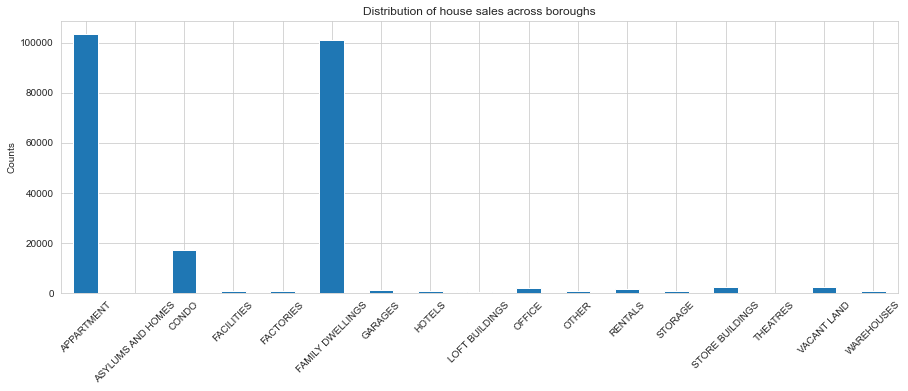

In [16]:
ax=Housedata['BUILDING CLASS CATEGORY'].value_counts().sort_index().plot(kind='bar', 
                                                         rot=45, figsize= (15,5), 
                                                         title='Distribution of house sales across boroughs')
ax.set_ylabel('Counts')

`apartment` and `family dwellings` make up the majority of the housing sales market, and both have an equal share, far exceeding other housing types.

In [17]:
## Data processing to get correct data into bins:
from bokeh.plotting import figure, output_file, save

#NoOutlier = Housedata[(Housedata['SALE PRICE']>over_price)]

max_out= 8000000
min_out = 100

NoOutlier = Housedata[(Housedata['SALE PRICE']<max_out) & (Housedata['SALE PRICE']>min_out)] 
focus_types = ['APPARTMENT','FAMILY DWELLINGS']

list_of_classes =NoOutlier[NoOutlier['BUILDING CLASS CATEGORY'].isin(focus_types)]['BUILDING CLASS CATEGORY'].unique()


HistData={}
for indx,i in enumerate(list_of_classes):
    bins = 50 
    dataframe=NoOutlier[NoOutlier['BUILDING CLASS CATEGORY']==i]
    column = 'SALE PRICE'

    hist, edges = np.histogram(dataframe[column], bins = bins)
    hist_df = pd.DataFrame({column: hist,
                        "left": edges[:-1],
                        "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]
    
    
    HistData[i]=ColumnDataSource(hist_df)
    
    
# create plot 
reset_output()
output_notebook()

# initialize standard settings for the plot: 
plot = figure(plot_height = 400, plot_width = 700, title = 'House SALE PRICE in New York',
      x_axis_label = 'USD',
      y_axis_label = "Count")  

# Create empty dictionary for bars
bar={}
# create empty legend list
legend_it = []

# define colors for the boroughs
colors = Category20[len(list_of_classes)+3]

for indx,i in enumerate(list_of_classes):
    src = HistData[i]
    
    bar[i]=plot.quad(top=column, bottom=0.1, left = "left", right = "right",
                       source=src, color=colors[indx+1], muted_alpha=0.2,muted=True, legend_label = i) 
    
    
    #legend_it.append((i, [bar[i]]))

#legend = Legend(items=legend_it)
#legend.click_policy="mute"
#plot.add_layout(legend, 'right')

#plot.legend.location = "top_right"
plot.legend.click_policy="hide"


#displays plot:
show(plot) 

output_file("bokeh_prices_types.html")
save(plot)

Loading BokehJS ...

'/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Social_data_project/bokeh_prices_types.html'

#### Histogram of the prices in different types of buildings 
This does plot shows that there is clear differentiation between the different types with regards to the price. The price range of apartment is relatively wider, while the prices of family dwellings are more concentrated.

### Price vs. Size of land

It could be interesting to investigate the size of land you will get for the money in New York.

In [18]:
# removing string artifacts like "-"
Housedata=Housedata[(Housedata['GROSS SQUARE FEET'].str.contains('- 0')==False)]                     
Housedata['GROSS SQUARE FEET'] = [float(row.replace(',','')) if type(row)==str else row for row in Housedata['GROSS SQUARE FEET']]

Housedata=Housedata[(Housedata['LAND SQUARE FEET'].str.contains('- 0')==False)]                     
Housedata['LAND SQUARE FEET'] = [float(row.replace(',','')) if type(row)==str else row for row in Housedata['LAND SQUARE FEET']]

In [19]:
# the focus type in this investigation is family dwellings as apartment (the other category do not have any land)
focus_types = ['FAMILY DWELLINGS','APARTMENT']
DA_out = Housedata[Housedata['BUILDING CLASS CATEGORY'].isin(focus_types)]

In [20]:
# not considering outlier prices in this plot due to visualization purpose
DA_out=DA_out[(DA_out['SALE PRICE']<4000000) 
              & (DA_out['LAND SQUARE FEET']>0) 
              & (DA_out['LAND SQUARE FEET']<40000)]

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=DA_out, x='LAND SQUARE FEET', y='SALE PRICE', hue='BOROUGH',style='BOROUGH')

<AxesSubplot:xlabel='LAND SQUARE FEET', ylabel='SALE PRICE'>

<AxesSubplot:xlabel='GROSS SQUARE FEET', ylabel='SALE PRICE'>

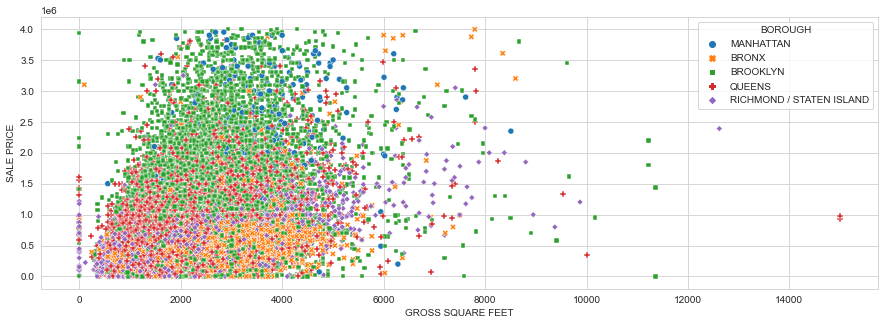

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=DA_out, x='GROSS SQUARE FEET', y='SALE PRICE', hue='BOROUGH',style='BOROUGH')

#### Scatterplot 
This scatterplot shows the distribution of land square feet of the family drewllings. 
And as shown the data indicates if family wants to keep the prices low, and want have large outdoor land, Queens is the way to go. Where as Manhattan and Brooklyn  (opposite to Queens) offer smaller family drewllings.

#### Exporting data
This is done since we have processed the housing data that will be used for further analysis with crime data

In [23]:
Housedata.to_csv (r'HousedataProcessed.csv', index = False, header=True)